# Lab 3 - UDMA

This Jupyter Notebook (JN) is the final part of Lab3. This will show you how to use the UDMA from a JupyterLab notebook to interface your custom hardware through the ComBlock.

In this Lab exercise you will not only interact with the design in the Zynq SoC, but also with the external DAC and ADC boards plugged into the ZedBoard PMOD connectors. To do so, we have prepared an environment based on Python 3.8 and the required libraries to execute the workflow described next:

1) **Python**
  - Instantiate a UDMA object
  - Connect the UDMA object to the Zedboard
2) **Python + UDMA <---> Zynq SoC**
  - Complete the missing parts in the code denoted by ?? signs
  - Test the ALU
  - Test the Flopoco division block
  - Test the HLS division block
3) **Python**
  - Perform the appropriate casting to the floating point values returned by the division blocks

- Author(s): Werner Florian, Agustin Silva (MLab/ICTP) - 2023/10/31 (version 1.0)
- Update(s):

## Importing libraries


In [1]:
# == MLab library ==
import udma #MLab UDMA library

# Bit manipulation library
from struct import pack, unpack

from time import sleep

# Interfacing with hardware via UDMA

## Setting up UDMA and ZedBoard parameters

IP Address and port of your ZedBoard development board

In [2]:
IP_ADDRESS = '192.168.1.10' # Set your ZedBoard IP Address here
IP_PORT = 7

Initializing UDMA class instance with provided IP settings. Here we are creating a `UDMA` object and giving it the `zedBoard` name. This name can be chosen at random.

In [3]:
zedBoard = udma.UDMA_CLASS(IP_ADDRESS, IP_PORT)

### Connecting to ZedBoard

Tries indefinitely until connection is successful

In [4]:
connectionStatus = 0
while(connectionStatus == 0):
    connectionStatus = zedBoard.connect()
    sleep(1)

Disable unused logging to speed up data transactions, logging capabilities are provided via UART and can be turn on or off on command. Check the **GTKterm** window.

In [5]:
_ = zedBoard.log(0)

## Interacting with ZedBoard via UDMA

### Write values to the registers

To start we will try writing and reading the registers of the **ComBlock**.

The following register map will be useful when trying to remember which register was connected to which port.

![reg_map](img/reg_map.png)



In [6]:
# Output registers
CB_DATA_A_REG		    = 0 # variable data a
CB_DATA_B_REG		    = 1 # variable data b
CB_OP_CODE_REG	        = 2 # operation code register
CB_DIVHLS_A_REG		    = 3 # variable data a
CB_DIVHLS_B_REG		    = 4 # variable data b

# Input registers
CB_ALU_STATUS_REG	    = 0 # ALU status flag
CB_ALU_DATA_O_REG	    = 1 # ALU data operation result
CB_DIV_EXN_REG		    = 2 # Division exn flag
CB_DIV_DATA_O_REG	    = 3 # Division data operation result
CB_DIVHLS_DATA_O_REG    = 4 # Read slide switches

To start we invoke our `UDMA` object, the `zedBoard`. This object provides the following functions to interact with the registers:

`.write_reg(int32 reg, int32 data) -> list [head, 0]`

`.read_reg(int32 reg) -> [head, rx_dat]`

Both functions return a list which contains two entries, `head` and the result of the operation.

```
head [0]: error report
	0 -> Failure
	1 -> Success
	2 -> overflow
	3 -> underflow
	4 -> logging enabled
	5 -> logging disabled
head [1]: length
```

Using this information you should now proceed to replicate the tests from [Lab 2: ComBlock and RTL](https://gitlab.com/ictp-mlab/smr-3891/-/wikis/Labs/Lab-2-ComBlock-and-RTL#51-slide-switches-interaction-with-the-comblock-ip)

You should replicate the following code for all the ALU operations and both division blocks. As in the previous laboratory the results from the division blocks makes little to no sense. This is the subject of the next section.

To read only the data from the registers you can access the item in the tuples adding `[1][0]` the fist square brackets extract the `rx_dat` and the second takes the first element.

`.read_reg(int32 reg)[1][0]`

In [7]:
print("### Testing the ALU")

data_a = 10
data_b = 5

# write the operands and op_code
zedBoard.write_reg(reg = CB_DATA_A_REG, data = data_a)
zedBoard.write_reg(reg = CB_DATA_B_REG, data = data_b)

print(f"Data in A = {data_a}, B = {data_b}")

for i in range(8):
    zedBoard.write_reg(reg = CB_OP_CODE_REG, data = i)
    # read the head and the result
    status = zedBoard.read_reg(reg = CB_ALU_STATUS_REG)[1][0]
    print(f"operation status: {status}")
    data_out = zedBoard.read_reg(reg = CB_ALU_DATA_O_REG)[1][0]
    # show the result
    print(f"operation option = {i}, result = {data_out}")

print("\n### Testing the Flopoco division block")
exn = zedBoard.read_reg(reg = CB_DIV_EXN_REG)[1][0]
print(f"operation exn: {exn}")

data_out = zedBoard.read_reg(reg = CB_DIV_DATA_O_REG)[1][0]
print(f"division R: {data_out}\n")

print("### Testing the HLS division block")
zedBoard.write_reg(reg = CB_DIVHLS_A_REG, data = data_a)
zedBoard.write_reg(reg = CB_DIVHLS_B_REG, data = data_b)
data_out_hls = zedBoard.read_reg(reg = CB_DIVHLS_DATA_O_REG)[1][0]
print(f"division R: {data_out_hls}")

### Testing the ALU
Data in A = 10, B = 5
operation status: 2
operation option = 0, result = 0
operation status: 0
operation option = 1, result = 15
operation status: 0
operation option = 2, result = 5
operation status: 0
operation option = 3, result = 15
operation status: 2
operation option = 4, result = 0
operation status: 0
operation option = 5, result = 15
operation status: 2
operation option = 6, result = 0
operation status: 0
operation option = 7, result = 320

### Testing the Flopoco division block
operation exn: 1
division R: 1065353221

### Testing the HLS division block
division R: 2143289344


## Floating point representation

Floating point is radically different from other representations in the way that it encodes quantities.
In a similar way to scientific notation, floating point quantities are encoded in an integer value called *significand* that is scaled in the *base* (b) with an *exponent* (e) and *precision* of the mantissa (p), shown in the following equation:

![floating](img/fp.png)

The *significand* can also be simplified when to the *mantissa* can represent the significant digits of the fraction, in this case the precision must include the implicit extra digit.

The standard used by the division blocks is the IEEE 754, where *b = 2* and *p = 24*.
It prescribes a 32 bit word that is split as follows, the *fraction* or *mantissa* denotes that one unit is inferred as an extra digit making the resulting *significand = 1.fraction* in the appropriate base.
This extra digit is why the precision is actually 24:

![standard](img/ieee754.png)

The *significand* from a binary fraction is defined as:

$$ significand = 1 + \frac{mantissa}{2^{p-1}} $$

Now we will proceed to cast the 32 bit word from the division blocks to IEEE 754.
This will make the values usable in Python as common floating point.

$$ floating\_point = (-1)^{sign} * significand * 2^{exponent - 127}$$

The next part consists in writing the floating point values in the correct representation in the **ComBlock** and casting the output values form the division blocks to floating point.

In [8]:
def raw_2_float(raw_val: int):
    sign = raw_val >> 31
    exponent = (raw_val >> 23) & 0xFF
    mantissa = raw_val & 0x7FFFFF
    return sign, exponent, mantissa

def build_ieee754(sign: int, exponent: int, mantissa: int):
    return (-1)**(sign) * (1 + mantissa/(2**(24-1))) * 2**(exponent - 127)

sign, exponent, mantissa = raw_2_float(data_out)
print(sign, exponent, mantissa)

float_data_out = build_ieee754(sign, exponent, mantissa)
print(f"Float IEEE 754 representation of our raw data {float_data_out:.30f}")

0 127 5
Float IEEE 754 representation of our raw data 1.000000596046447753906250000000


The results makes little to no sense given that we all know that $10 / 5 \neq 1.000000596046447753906250000000$. 
And in the case of the HLS we obtain a value that is equivalent to `NaN` according to the IEEE 754 standard.
This signals another error in the way we are using this blocks so far.
The output is considered floating point and casted correctly, but what is missing is casting the inputs to the correct floating point format for the correct interpretation inside the IPs.

We can cast our floating point values to their equivalent representation in integer by doing the previous steps in an inverse way.

1. Obtain the *sign*, *exponent*, and *mantissa* bits.
2. Build the integer representation with the correct masks and shifts.
3. Profit!

In [9]:
def float_2_raw(float_val: float):
    float_val_hex = float_val.hex()
    sign = float_val < 0
    exponent = int(float_val_hex.partition('p')[2]) + 127
    mantissa = int(float_val_hex[float_val_hex.find('.') + 1:float_val_hex.find('p')], 16) >> 29
    return sign, exponent, mantissa

def build_int(sign, exponent, mantissa):
    return (sign << 31) + (exponent << 23) + mantissa

sign, exponent, mantissa = float_2_raw(10.1)
print(sign, exponent, mantissa)

int_data_out = build_int(sign, exponent, mantissa)
print(f"Integer representation of our Float IEEE 754 {int_data_out:x}")

False 130 2202009
Integer representation of our Float IEEE 754 41219999


Now that you have all the tools you need to write floating point values to your blocks and re-interpret the result into floating point, proceed to test them.

In [10]:
print("### Testing the division blocks")

fp_data_a = 10.0
fp_data_b = 5.0

# Use the previous functions to translate the floating point IEEE 754 to raw bits in the following space
[sign_a, exponent_a, mantissa_a] = float_2_raw(fp_data_a)
[sign_b, exponent_b, mantissa_b] = float_2_raw(fp_data_b)

# Write the operands to the appropriate blocks inputs
nfp_data_a = build_int(sign_a, exponent_a, mantissa_a)
nfp_data_b = build_int(sign_b, exponent_b, mantissa_b)

print("\n### Testing the Flopoco division block")

zedBoard.write_reg(reg = CB_DATA_A_REG, data = nfp_data_a)
zedBoard.write_reg(reg = CB_DATA_B_REG, data = nfp_data_b)

exn = zedBoard.read_reg(reg = CB_DIV_EXN_REG)[1][0]
print(f"operation exn: {exn}")

data_out = zedBoard.read_reg(reg = CB_DIV_DATA_O_REG)[1][0]
print(f"Raw division R: {data_out}")

# Convert from the raw bits from the UDMA to floating point using the previous functions and save it in a variable named float_data_out
#...
#...
[sign_o, exponent_o, mantissa_o] = raw_2_float(data_out)
float_data_out = build_ieee754(sign_o, exponent_o, mantissa_o)

print(f"Float division R: {float_data_out}\n")

print("### Testing the HLS division block")

zedBoard.write_reg(reg = CB_DIVHLS_A_REG, data = nfp_data_a)
zedBoard.write_reg(reg = CB_DIVHLS_B_REG, data = nfp_data_b)

data_out_hls = zedBoard.read_reg(reg = CB_DIVHLS_DATA_O_REG)[1][0]
print(f"Raw division R: {data_out_hls}")

# Convert from the raw bits from the UDMA to floating point using the previous functions and save it in a variable named float_data_out_hls
#...
#...
[sign_o, exponent_o, mantissa_o] = raw_2_float(data_out_hls)
float_data_out_hls = build_ieee754(sign_o, exponent_o, mantissa_o)

print(f"Float division R: {float_data_out_hls}\n")

### Testing the division blocks

### Testing the Flopoco division block
operation exn: 1
Raw division R: 1073741824
Float division R: 2.0

### Testing the HLS division block
Raw division R: 1073741824
Float division R: 2.0



There are some functions that will prove useful in this endeavour:

```pack(format, v)```

Return a bytes object containing the values `v`, packed according to the format string `format`.

```unpack(format, buffer)```

Unpack from the buffer `buffer` according to the format string `format`. The result is a tuple even if it contains exactly one item.

The format string for floating point is `"f"` and it requires a 4 bytes buffer for unpack.

For example:

    a = pack('f', 2.5)  # a stores the binary representation of 2.5 in IEEE 754 format
    unpack('f', a)      # unpacks the binary representation of a into "a" into a IEEE 754 float

In [11]:
float_a = 2.5
binary_a = pack('f', float_a)
int_a = int.from_bytes(binary_a, byteorder='little')
zedBoard.write_reg(CB_DATA_A_REG, int_a)
zedBoard.write_reg(CB_DIVHLS_A_REG, int_a)

float_b = -0.24
binary_b = pack('f', float_b)
int_b = int.from_bytes(binary_b, byteorder='little')
zedBoard.write_reg(CB_DATA_B_REG, int_b)
zedBoard.write_reg(CB_DIVHLS_B_REG, int_b)

int_c = zedBoard.read_reg(CB_DIV_DATA_O_REG)[1][0]
byte_c = int_c.to_bytes(length=4, byteorder='little')
float_c = unpack('f', byte_c)[0]

int_c_hls = zedBoard.read_reg(CB_DIVHLS_DATA_O_REG)[1][0]
byte_c_hls = int_c_hls.to_bytes(length=4, byteorder='little')
float_c_hls = unpack('f', byte_c_hls)[0]

print("SOFTWARE -> {:.9f} = {:.6f} / {:.6f}".format(float_a/float_b, float_a, float_b))
print("FLOPOCO  -> {:.9f} = {:.6f} / {:.6f}".format(float_c, float_a, float_b))
print("HLS      -> {:.9f} = {:.6f} / {:.6f}".format(float_c_hls, float_a, float_b))

SOFTWARE -> -10.416666667 = 2.500000 / -0.240000
FLOPOCO  -> -10.416666985 = 2.500000 / -0.240000
HLS      -> -10.416666985 = 2.500000 / -0.240000


# Challenge: Flopoco vs. HLS

Now we can check if the results from our HLS divisor IP are correct and compare them with the Flopoco block.
To do so we must first load the operands in the correct ComBlock registers, read the result, and cast it to float to compare.

You should also check how both handle infinite cases, underflow, and not-a-number.

In [12]:
import matplotlib.pyplot as plt

In [22]:
sol_s = []
sol_f = []
sol_h = []

for i in range (10,1000):
    float_a = i-1
    binary_a = pack('f', float_a)
    int_a = int.from_bytes(binary_a, byteorder='little')
    zedBoard.write_reg(CB_DATA_A_REG, int_a)
    zedBoard.write_reg(CB_DIVHLS_A_REG, int_a)

    float_b = i+1
    binary_b = pack('f', float_b)
    int_b = int.from_bytes(binary_b, byteorder='little')
    zedBoard.write_reg(CB_DATA_B_REG, int_b)
    zedBoard.write_reg(CB_DIVHLS_B_REG, int_b)

    int_c = zedBoard.read_reg(CB_DIV_DATA_O_REG)[1][0]
    byte_c = int_c.to_bytes(length=4, byteorder='little')
    float_c = unpack('f', byte_c)[0]

    int_c_hls = zedBoard.read_reg(CB_DIVHLS_DATA_O_REG)[1][0]
    byte_c_hls = int_c_hls.to_bytes(length=4, byteorder='little')
    float_c_hls = unpack('f', byte_c_hls)[0]

    print("{:.1f}, SOFTWARE -> {:.9f}, FLOPOCO -> {:.9f}, HLS -> {:.9f}".format(i, float_a/float_b, float_c, float_c_hls))
    sol_s.append(float_a/float_b)
    sol_f.append(float_c)
    sol_h.append(float_c_hls)



10.0, SOFTWARE -> 0.818181818, FLOPOCO -> 0.818181813, HLS -> 0.818181813
11.0, SOFTWARE -> 0.833333333, FLOPOCO -> 0.833333313, HLS -> 0.833333313
12.0, SOFTWARE -> 0.846153846, FLOPOCO -> 0.846153855, HLS -> 0.846153855
13.0, SOFTWARE -> 0.857142857, FLOPOCO -> 0.857142866, HLS -> 0.857142866
14.0, SOFTWARE -> 0.866666667, FLOPOCO -> 0.866666675, HLS -> 0.866666675
15.0, SOFTWARE -> 0.875000000, FLOPOCO -> 0.875000000, HLS -> 0.875000000
16.0, SOFTWARE -> 0.882352941, FLOPOCO -> 0.882352948, HLS -> 0.882352948
17.0, SOFTWARE -> 0.888888889, FLOPOCO -> 0.888888896, HLS -> 0.888888896
18.0, SOFTWARE -> 0.894736842, FLOPOCO -> 0.894736826, HLS -> 0.894736826
19.0, SOFTWARE -> 0.900000000, FLOPOCO -> 0.899999976, HLS -> 0.899999976
20.0, SOFTWARE -> 0.904761905, FLOPOCO -> 0.904761910, HLS -> 0.904761910
21.0, SOFTWARE -> 0.909090909, FLOPOCO -> 0.909090936, HLS -> 0.909090936
22.0, SOFTWARE -> 0.913043478, FLOPOCO -> 0.913043499, HLS -> 0.913043499
23.0, SOFTWARE -> 0.916666667, FLOPOCO

(0.99, 1.0)

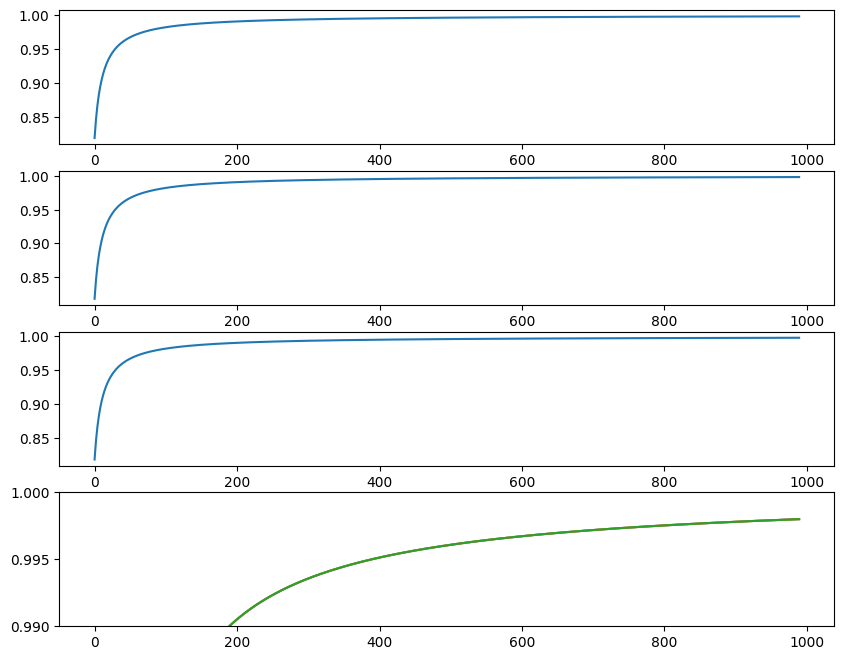

In [21]:
plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
plt.plot(sol_s)
plt.subplot(4,1,2)
plt.plot(sol_f)
plt.subplot(4,1,3)
plt.plot(sol_h)
plt.subplot(4,1,4)
plt.plot(sol_s)
plt.plot(sol_f)
plt.plot(sol_h)
plt.ylim([0.99,1])